In [35]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer

from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO

from sklearn.preprocessing import OneHotEncoder
import datetime

In [2]:
Features = pd.read_csv('../cleaned_data/TS_2018.csv')
#Features['tpep_pickup_datetime'] = pd.to_datetime(Features['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S')
Features = Features.dropna()
Features.head()

,Unnamed: 0,tpep_pickup_datetime,DOM,DOW,HOD,bad_weather,date,is_holiday,lag1,lag2,...,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,trip_count
0,0,2018-07-02 00:00:00,2,0,0,0,2018-07-02,0,416,401,...,267,146,82,97,184,146,207,324,491,273
1,1,2018-07-02 01:00:00,2,0,1,0,2018-07-02,0,273,416,...,428,267,146,82,97,184,146,207,324,147
2,2,2018-07-02 02:00:00,2,0,2,0,2018-07-02,0,147,273,...,470,428,267,146,82,97,184,146,207,83
3,3,2018-07-02 03:00:00,2,0,3,0,2018-07-02,0,83,147,...,550,470,428,267,146,82,97,184,146,76
4,4,2018-07-02 04:00:00,2,0,4,0,2018-07-02,0,76,83,...,495,550,470,428,267,146,82,97,184,73


In [3]:
Features['tpep_pickup_datetime'] = pd.to_datetime(Features['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S')

In [4]:
Features = Features.drop(columns = 'Unnamed: 0')
Features = Features.drop(['DOM'],axis =1 )

### 2018 July - Dec data

In [5]:
Features.head()

,tpep_pickup_datetime,DOW,HOD,bad_weather,date,is_holiday,lag1,lag2,lag3,lag4,...,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,trip_count
0,2018-07-02 00:00:00,0,0,0,2018-07-02,0,416,401,479,434,...,267,146,82,97,184,146,207,324,491,273
1,2018-07-02 01:00:00,0,1,0,2018-07-02,0,273,416,401,479,...,428,267,146,82,97,184,146,207,324,147
2,2018-07-02 02:00:00,0,2,0,2018-07-02,0,147,273,416,401,...,470,428,267,146,82,97,184,146,207,83
3,2018-07-02 03:00:00,0,3,0,2018-07-02,0,83,147,273,416,...,550,470,428,267,146,82,97,184,146,76
4,2018-07-02 04:00:00,0,4,0,2018-07-02,0,76,83,147,273,...,495,550,470,428,267,146,82,97,184,73


In [6]:
# Keep the timeline information
train_time = Features['tpep_pickup_datetime'].iloc[0:2213]
valid_time = Features['tpep_pickup_datetime'].iloc[2213:2933]
trainopt_time = Features['tpep_pickup_datetime'].iloc[0:2933]
test_time = Features['tpep_pickup_datetime'].iloc[2933:]

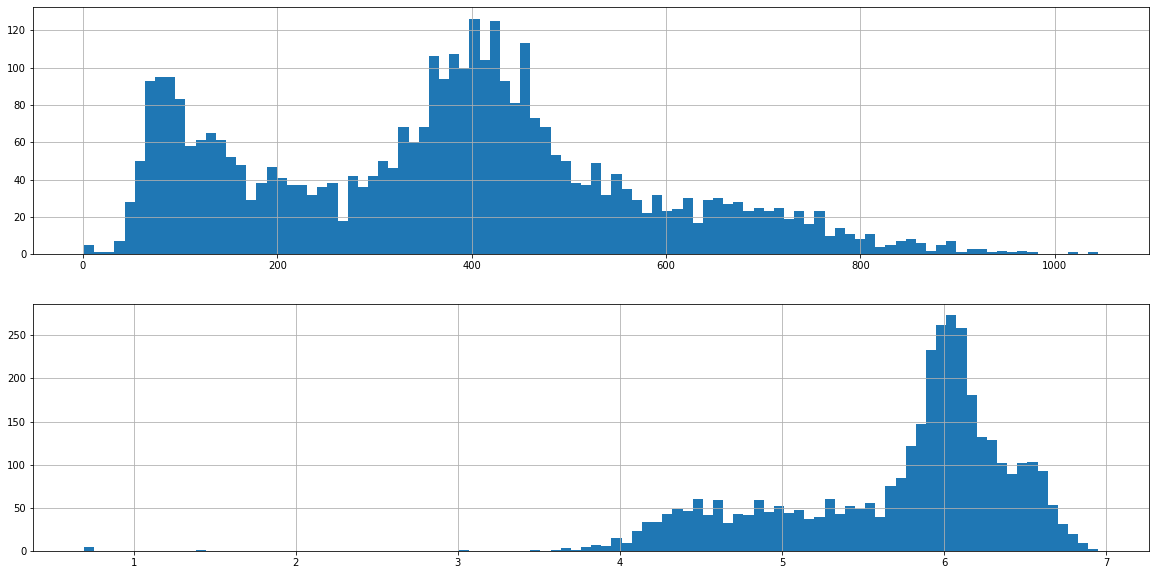

In [7]:
df = Features.copy()
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
df['trip_count'].hist(bins=100, ax=axes[0])
df['trip_count'] = np.log1p(df['trip_count'])
df['trip_count'].hist(bins=100, ax=axes[1])
plt.show()

In [8]:
# Prepare Feature for train-validation-test split
Features = Features.drop(['date','tpep_pickup_datetime'],axis=1)
Features.head(10)

,DOW,HOD,bad_weather,is_holiday,lag1,lag2,lag3,lag4,lag5,lag6,...,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,trip_count
0,0,0,0,0,416,401,479,434,523,635,...,267,146,82,97,184,146,207,324,491,273
1,0,1,0,0,273,416,401,479,434,523,...,428,267,146,82,97,184,146,207,324,147
2,0,2,0,0,147,273,416,401,479,434,...,470,428,267,146,82,97,184,146,207,83
3,0,3,0,0,83,147,273,416,401,479,...,550,470,428,267,146,82,97,184,146,76
4,0,4,0,0,76,83,147,273,416,401,...,495,550,470,428,267,146,82,97,184,73
5,0,5,0,0,73,76,83,147,273,416,...,453,495,550,470,428,267,146,82,97,84
6,0,6,0,0,84,73,76,83,147,273,...,392,453,495,550,470,428,267,146,82,124
7,0,7,0,0,124,84,73,76,83,147,...,394,392,453,495,550,470,428,267,146,200
8,0,8,0,0,200,124,84,73,76,83,...,504,394,392,453,495,550,470,428,267,283
9,0,9,0,0,283,200,124,84,73,76,...,679,504,394,392,453,495,550,470,428,410


In [9]:
# Train validation test split
train_df_s = Features.iloc[0:2213]
train_dfx_s = train_df_s.drop(['trip_count'],axis=1)
train_dfy_s = train_df_s.trip_count

valid_df_s = Features.iloc[2213:2933]
valid_dfx_s = valid_df_s.drop(['trip_count'],axis=1)
valid_dfy_s = valid_df_s.trip_count

train_opt_df_s = Features.iloc[0:2933]
train_opt_dfx_s = train_opt_df_s.drop(['trip_count'],axis=1)
train_opt_dfy_s = train_opt_df_s.trip_count

test_df_s = Features.iloc[2933:]
test_dfx_s = test_df_s.drop(['trip_count'],axis=1)
test_dfy_s = test_df_s.trip_count

In [10]:
# Normalization - MinMaxScaler

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_dfx_scaled = pd.DataFrame(scaler.fit_transform(train_dfx_s), columns= train_dfx_s.columns)
valid_dfx_scaled = pd.DataFrame(scaler.fit_transform(valid_dfx_s), columns= valid_dfx_s.columns)
test_dfx_scaled = pd.DataFrame(scaler.fit_transform(test_dfx_s), columns= test_dfx_s.columns)

In [12]:
#new dataframe
train_dfx_scaled['trip_count'] = train_df_s['trip_count']
valid_dfx_scaled['trip_count'] = valid_df_s['trip_count'].reset_index(drop = True)
test_dfx_scaled['trip_count'] = test_df_s['trip_count'].reset_index(drop = True)

### Linear Regression Model

In [13]:
# Linear Regression
lm_train = smf.ols(formula = 'trip_count ~ C(bad_weather)+C(is_holiday)+'+'+'.join(train_dfx_scaled.columns[4:28]), data = train_dfx_scaled).fit()
print(lm_train.summary())

                            OLS Regression Results                            
Dep. Variable:             trip_count   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     687.1
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        01:32:24   Log-Likelihood:                -12409.
No. Observations:                2213   AIC:                         2.487e+04
Df Residuals:                    2186   BIC:                         2.503e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                46.32

In [14]:
lmy_v = lm_train.predict(valid_dfx_scaled)
R2_OS = r2_score(valid_dfx_scaled.trip_count,lmy_v)
MAE = mean_absolute_error(valid_dfx_scaled.trip_count,lmy_v)
print('The validation sample R2 is',R2_OS)
print('The validation mean absolute error is',MAE)

The validation sample R2 is 0.8143968809634787
The validation mean absolute error is 68.54920760060448


In [15]:
lmy_t = lm_train.predict(test_dfx_scaled)
R2_OS = r2_score(test_dfx_scaled.trip_count,lmy_t)
MAE = mean_absolute_error(test_dfx_scaled.trip_count,lmy_t)
print('The test sample R2 is',R2_OS)
print('The test mean absolute error is',MAE)

The test sample R2 is 0.8806324063347358
The test mean absolute error is 49.58203202856538


### LR Feature Selection

In [16]:
# The regression function based on the feature selection
n = len(train_dfx_scaled.columns[2:28])

def AdjR2(flag):
    
    #1--feature included
    #0--feature excluded
    formstr='trip_count~C(bad_weather)+C(is_holiday)'
    for i in range(len(flag)):
        if flag[i]==1:
            formstr += '+'+'+'.join(train_dfx_scaled.columns[i+2:i+3])
    lm = smf.ols(formula = formstr, data = train_dfx_scaled).fit()
    lmy = lm.predict(valid_dfx_scaled)
    y_err = lmy-valid_dfx_scaled.trip_count
    y_norm = valid_dfx_scaled.trip_count - sum(valid_dfx_scaled.trip_count)/len(valid_dfx_scaled.trip_count)
    # Adjusted R^2
    R2_OS = 1 - y_err.dot(y_err) / y_norm.dot(y_norm) * (n-3-1) / (n-3-sum(flag)-1)
    return lm, R2_OS

In [17]:
# Feature selection based on p-values
def DropP(threshold = 1):
    flag_p = (AdjR2([1]*(n-3))[0]).pvalues < threshold
    print('Validation R^2 is %f'%AdjR2(flag_p)[1])
    print(AdjR2(flag_p)[0].summary())

In [18]:
DropP(0.05)

Validation R^2 is 0.443947
                            OLS Regression Results                            
Dep. Variable:             trip_count   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1209.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        01:32:25   Log-Likelihood:                -12467.
No. Observations:                2213   AIC:                         2.496e+04
Df Residuals:                    2198   BIC:                         2.505e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Int

In [19]:
#find best feature selection that maximize validation adjusted R2
def FindBestI():
    flag = np.zeros(n)
    r2max = 0             
    while True:
        flag_mat = np.maximum(np.eye(n),flag) 
        
        r2 = np.apply_along_axis(AdjR2,1,flag_mat)[:,1]  
        temp = r2.max()
        if temp > r2max:
            r2max = temp
            flag = flag_mat[r2.argmax()]  
        else:
            break                         
    return flag

flag = FindBestI()             

In [20]:
lm_best,r2_best = AdjR2(flag)

col = ['intercept'] + list(train_dfx_scaled.columns[:28])

ix = [col[i+3] for i in range(n) if flag[i]==1]

b = pd.DataFrame({'Pvalues':AdjR2([1]*n)[0].pvalues, 'Keeper':col})

c = 'forestgreen'

def highlight_pval(val):
    color = c if val in ix else 'white'
    return 'background-color: %s'%color

b.style.applymap(highlight_pval, subset=['Keeper']).\
    bar(subset = ['Pvalues'], color=c)

,Pvalues,Keeper
Intercept,4.37578e-05,intercept
C(bad_weather)[T.1.0],0.497629,DOW
C(is_holiday)[T.1.0],0.000495657,HOD
bad_weather,0.497629,bad_weather
is_holiday,0.000495657,is_holiday
lag1,3.1686e-227,lag1
lag2,1.14829e-15,lag2
lag3,2.77958e-05,lag3
lag4,0.444585,lag4
lag5,0.00122825,lag5


In [21]:
#features that best fit
print('Validation R^2 is %f'%r2_best)
print(lm_best.summary())

Validation R^2 is 0.766821
                            OLS Regression Results                            
Dep. Variable:             trip_count   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     3180.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        01:32:28   Log-Likelihood:                -12532.
No. Observations:                2213   AIC:                         2.508e+04
Df Residuals:                    2207   BIC:                         2.511e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Int

In [22]:
lmy_v = lm_best.predict(valid_dfx_scaled)
R2_OS = r2_score(valid_dfx_scaled.trip_count,lmy_v)
MAE = mean_absolute_error(valid_dfx_scaled.trip_count,lmy_v)
print('The validation sample R2 is',R2_OS)
print('The validation mean absolute error is',MAE)

The validation sample R2 is 0.7986181352350928
The validation mean absolute error is 70.55232361395956


In [23]:
lmy_te = lm_best.predict(test_dfx_scaled)
R2_OS = r2_score(test_dfx_scaled.trip_count,lmy_te)
MAE = mean_absolute_error(test_dfx_scaled.trip_count,lmy_te)
print('The test sample R2 is',R2_OS)
print('The test mean absolute error is',MAE)

The test sample R2 is 0.8673227635748966
The test mean absolute error is 50.64023795612603


In [24]:
valid_df = pd.concat([valid_df_s,valid_time],axis = 1)
test_df = pd.concat([test_df_s,test_time],axis = 1)

/Volumes/COSMOS/ProgramFiles/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


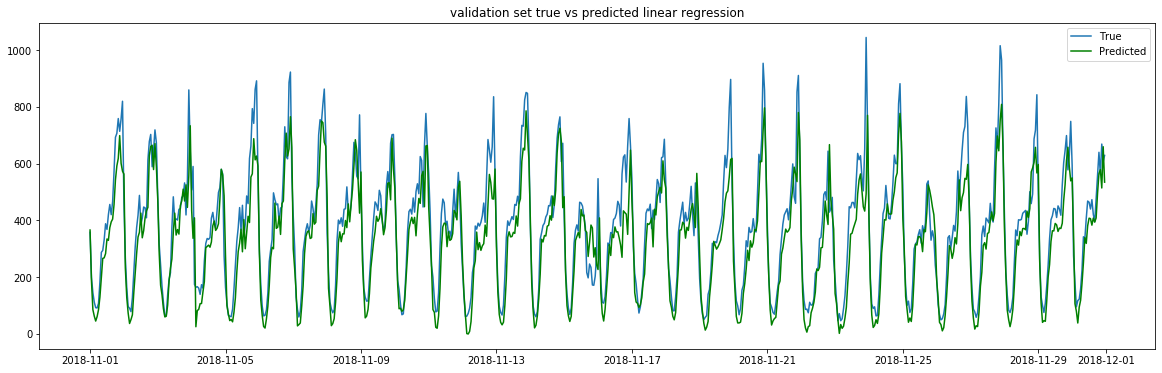

In [25]:
plt.figure(figsize=(20,6))
plt.plot(valid_df['tpep_pickup_datetime'],valid_dfx_scaled['trip_count'],label='True')
plt.plot(valid_df['tpep_pickup_datetime'],lmy_v, color='green',label='Predicted')
plt.title('validation set true vs predicted linear regression')
plt.legend()
plt.show()

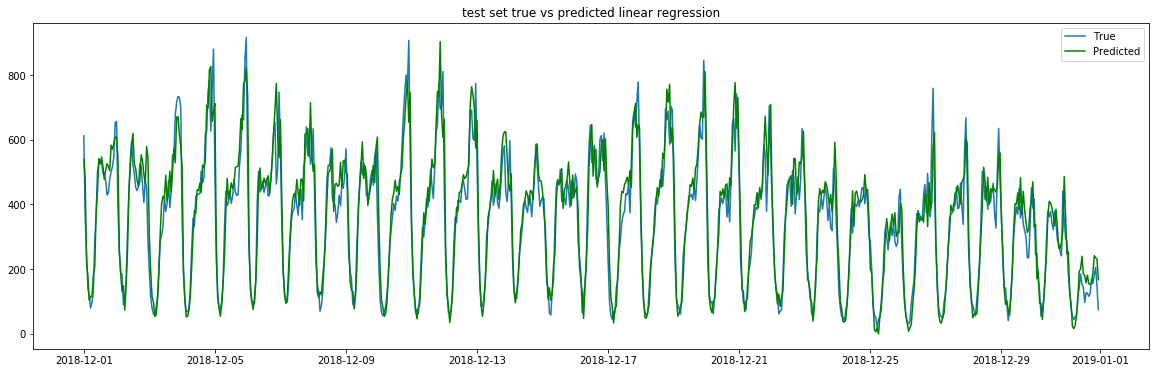

In [26]:
plt.figure(figsize=(20,6))
plt.plot(test_df['tpep_pickup_datetime'],test_dfx_scaled['trip_count'],label='True')
plt.plot(test_df['tpep_pickup_datetime'],lmy_te, color='green',label='Predicted')
plt.title('test set true vs predicted linear regression')
plt.legend()
plt.show()

### Decision Tree Classifier

In [27]:
depths = np.arange(1, 21)
num_leafs = [1, 5, 10, 15, 20, 50, 100]

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

param_grid = [{'decisiontreeregressor__max_depth':depths,
              'decisiontreeregressor__min_samples_leaf':num_leafs}]

pipe_tree = make_pipeline(tree.DecisionTreeRegressor(random_state=1))
RMSE_Scoring = make_scorer(root_mean_squared_error, greater_is_better=False)

gridDT = GridSearchCV(estimator=pipe_tree, param_grid=param_grid, scoring=RMSE_Scoring, cv=10)
bestDT = gridDT.fit(train_dfx_scaled.iloc[:,:28], train_dfx_scaled['trip_count'])

gridDT.best_params_

/Volumes/COSMOS/ProgramFiles/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'decisiontreeregressor__max_depth': 7,
 'decisiontreeregressor__min_samples_leaf': 10}

Text(0, 0.5, 'Normalized Gini Importance')

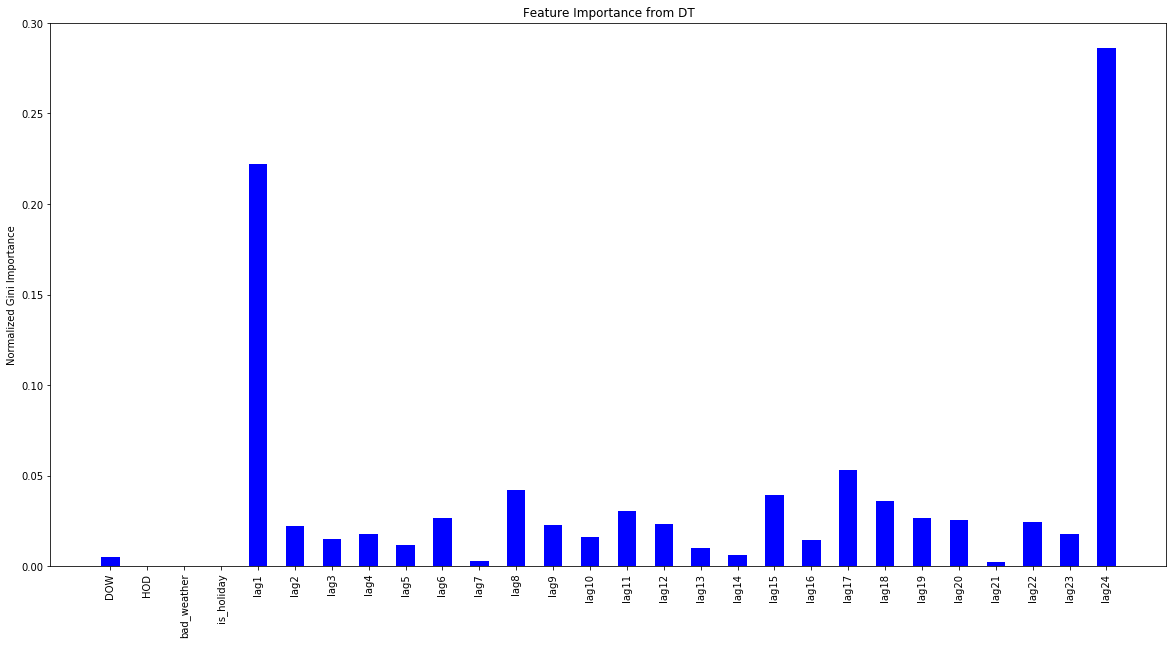

In [28]:
dt = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 10, max_depth = 7)
dt_best = dt.fit(train_dfx_scaled.iloc[:,:28], train_dfx_scaled['trip_count'])

dt_fi = dt_best.feature_importances_

fig, ax = plt.subplots(figsize = (20,10))

ax.bar(np.arange(28), dt.feature_importances_, width = 0.5, color = 'b')
ax.set_xticks(np.arange(len(dt.feature_importances_)))
ax.set_xticklabels(train_dfx_scaled.iloc[:,:28].columns.values, rotation = 90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

In [29]:
dt_feature_importance = pd.DataFrame(np.array([train_dfx_scaled.columns[:28],dt_fi]).T,\
                                  columns=['Features','Importance'])
dt_selected_fi = dt_feature_importance.sort_values(by='Importance',ascending=False)
dt_selected_fi[:10]

,Features,Importance
27,lag24,0.285897
4,lag1,0.221942
20,lag17,0.052888
11,lag8,0.0423236
18,lag15,0.039294
21,lag18,0.0358222
14,lag11,0.03039
9,lag6,0.0265623
22,lag19,0.0264978
23,lag20,0.0257054


In [30]:
print('In sample accuracy is',dt_best.score(train_dfx_scaled.iloc[:,:28], train_dfx_scaled['trip_count']))
print('Out of sample accuracy is',dt_best.score(test_dfx_scaled.iloc[:,:28], test_dfx_scaled['trip_count']))

In sample accuracy is 0.1211025756891098
Out of sample accuracy is 0.009408602150537635


In [31]:
y_rpred = dt_best.predict(train_dfx_scaled.iloc[:,:28])
y_tpred = dt_best.predict(test_dfx_scaled.iloc[:,:28])
print('Train RMSE score is',root_mean_squared_error(train_dfx_scaled['trip_count'], y_rpred))
print('Test RMSE score is',root_mean_squared_error(test_dfx_scaled['trip_count'], y_tpred))

Train RMSE score is 88.66921168459878
Test RMSE score is 95.16392902301152


### Random Forest Classifier

In [32]:
forest = RandomForestClassifier(random_state = 1)

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, n_jobs = -1)
bestF = gridF.fit(train_dfx_scaled.iloc[:,:28], train_dfx_scaled['trip_count'])

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


/Volumes/COSMOS/ProgramFiles/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 51.3min finished
/Volumes/COSMOS/ProgramFiles/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24.

In [33]:
gridF.best_params_

{'max_depth': 15,
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'n_estimators': 800}

Text(0, 0.5, 'MSE (blue); OOB (red)')

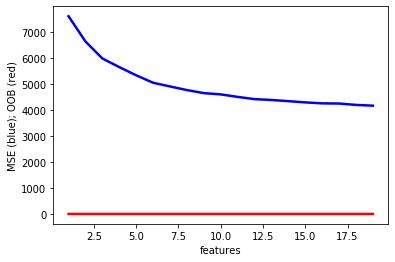

In [36]:
#from sklearn.metrics import mean_squared_error
oob_scores = []
mses = []
num_feats = range(1, 20)
for num_feat in num_feats:
    reg = RandomForestRegressor(n_estimators=800, max_features=num_feat, max_depth=15, min_samples_split = 15, min_samples_leaf = 5, bootstrap=True,oob_score=True)
    reg.fit(train_dfx_scaled.iloc[:,:28], train_dfx_scaled['trip_count'])
    ypred = reg.predict(test_dfx_scaled.iloc[:,:28])
    mses.append(mean_squared_error(test_dfx_scaled['trip_count'], ypred))
    oob_scores.append(reg.oob_score_)
plt.plot(num_feats, mses, color='b', linewidth=2.5)
plt.plot(num_feats, oob_scores, color='r', linewidth=2.5)
plt.xlabel("features")
plt.ylabel("MSE (blue); OOB (red)")

In [37]:
#select max features
max_feat = mses.index(min(mses))+1

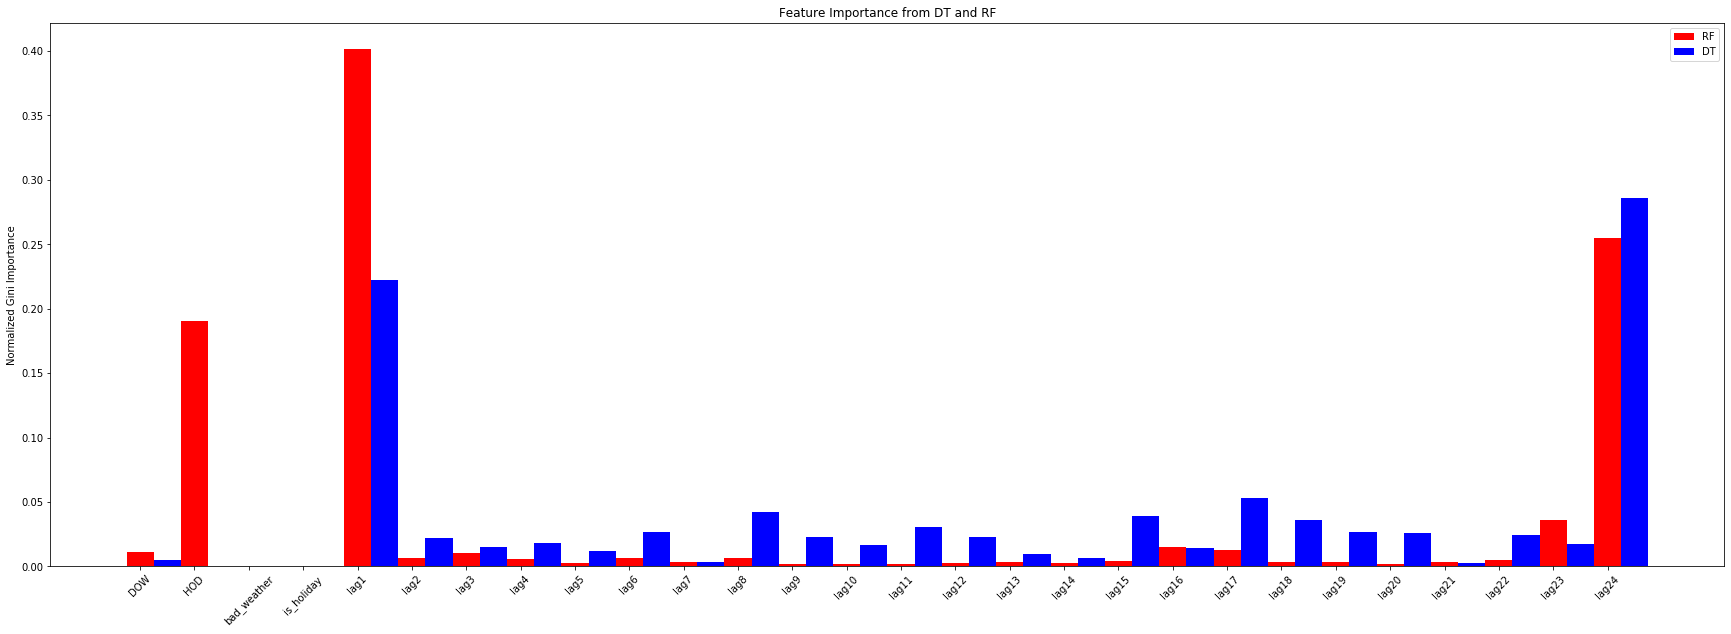

In [38]:
rf_best = RandomForestRegressor(n_estimators=800, max_features=max_feat, max_depth=15, min_samples_split = 15, min_samples_leaf = 5, bootstrap=True,oob_score=True)
rf_best = rf_best.fit(train_dfx_scaled.iloc[:,:28], train_dfx_scaled['trip_count'])

cols = train_dfx_scaled.iloc[:,:28].columns.values
rf_fi = rf_best.feature_importances_
dt_fi = dt_best.feature_importances_

fig, ax = plt.subplots(figsize = (30,10))

width = 0.5
ax.bar(np.arange(len(cols)), rf_fi, width, color='r', label='RF')
ax.bar(np.arange(len(cols))+width, dt_fi, width, color='b', label='DT')

ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=45)
plt.title('Feature Importance from DT and RF')
ax.set_ylabel('Normalized Gini Importance')
plt.legend(loc=1)

In [39]:
rf_feature_importance = pd.DataFrame(np.array([train_dfx_scaled.columns[:28],rf_fi]).T,\
                                  columns=['Features','Importance'])
rf_selected_fi = rf_feature_importance.sort_values(by='Importance',ascending=False)
rf_selected_fi[:10]

,Features,Importance
4,lag1,0.401698
27,lag24,0.255145
1,HOD,0.19048
26,lag23,0.0359798
19,lag16,0.0150136
20,lag17,0.0127922
0,DOW,0.0111045
6,lag3,0.0103396
11,lag8,0.00682014
5,lag2,0.00666522


In [40]:
ypred = rf_best.predict(test_dfx_scaled.iloc[:,:28])
print('OOB score is', rf_best.oob_score_)
print('Test RMSE score is', np.sqrt(mean_squared_error(test_dfx_scaled['trip_count'], ypred)))

OOB score is 0.9327985169076412
Test RMSE score is 64.93960572694704


In [41]:
print('in sample accuracy is',rf_best.score(train_dfx_scaled.iloc[:,:28], train_dfx_scaled['trip_count']))
print('out of sample accuracy is',rf_best.score(test_dfx_scaled.iloc[:,:28], test_dfx_scaled['trip_count']))

in sample accuracy is 0.9694055619992885
out of sample accuracy is 0.8797043442084272
